<a href="https://colab.research.google.com/github/jjrodcast/Notebook-Algorithms/blob/master/Stitching_Images_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget www.ivan-sipiran.com/downloads/Imagenes.zip
!unzip Imagenes.zip
!rm Imagenes.zip

--2020-03-28 16:13:06--  http://www.ivan-sipiran.com/downloads/Imagenes.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30498456 (29M) [application/zip]
Saving to: ‘Imagenes.zip’

Imagenes.zip        100%[===================>]  29.08M  21.6MB/s    in 1.3s    

2020-03-28 16:13:08 (21.6 MB/s) - ‘Imagenes.zip’ saved [30498456/30498456]

Archive:  Imagenes.zip
   creating: Imagenes/
  inflating: Imagenes/20191123_093200.jpg  
  inflating: Imagenes/Aviones.jpg    
  inflating: Imagenes/bird.png       
  inflating: Imagenes/cameraman.tif  
  inflating: Imagenes/centro1.jpg    
  inflating: Imagenes/centro2.png    
  inflating: Imagenes/claro.png      
  inflating: Imagenes/contrast1.jpg  
  inflating: Imagenes/contrast2.jpeg  
  inflating: Imagenes/contrast3.jpg  
  inflating: Imagenes/diagonalbars.png  
  inflating: Imagen

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [0]:
def visualizeImages(images):
    plt.figure(figsize=(15,15))
    for idx, image in enumerate(images):
        plt.subplot(3,3,idx+1), plt.imshow(image[:,:,::-1])
    plt.show()

def computeKeyPointsAndDescriptors(images):
  keypoints, descriptors = [], []
  for idx, image in enumerate(images):
    kaze = cv2.KAZE_create()
    kp, desc = kaze.detectAndCompute(image, None)
    keypoints.append(kp)
    descriptors.append(desc)
  return {'kps': keypoints, 'des': descriptors } 

def drawKeyPoints(images, computation):
  keypoints = computation['kps']
  descriptors = computation['des']
  for idx, image in enumerate(images):   
    print("#{} kps: {}, descriptiors: {}".format(idx, len(keypoints[idx]), descriptors[idx].shape))
    image_kps = cv2.drawKeypoints(image, keypoints[idx], image)
    cv2.imwrite('img_kps_{}.JPG'.format(idx + 1), image_kps)

def findHomography(images, computation, idx):
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
  descriptors = computation['des']
  keypoints = computation['kps']
  
  image_first = images[0]
  image_second = images[1]
  
  kps_first = keypoints[0]
  kps_second = keypoints[1]
  
  descriptor_first = descriptors[0]
  descriptor_second = descriptors[1]
  
  matches = bf.match(descriptor_first, descriptor_second)
  matches = sorted(matches, key=lambda x: x.distance)
        
  image_matched = cv2.drawMatches(image_first, kps_first, image_second, kps_second, matches[:10], image_first)
  #cv2.imwrite('img_matches_{}.JPG'.format(idx), image_matched)
  points_img_first = np.zeros((len(matches),2), dtype=np.float32)
  points_img_second = np.zeros((len(matches),2), dtype=np.float32)

  for i, match in enumerate(matches):
    points_img_first[i,:] = kps_first[match.queryIdx].pt
    points_img_second[i,:] = kps_second[match.trainIdx].pt
        
  h, _ = cv2.findHomography(points_img_second,points_img_first, cv2.RANSAC)
        
  return h

def createBlending(images, homography, idx):
    image_first = images[0]
    image_second = images[1]
    
    image_perspective = cv2.warpPerspective(image_second,homography, (image_first.shape[1] + image_second.shape[1], image_first.shape[0]))

    #cv2.imwrite('orginal_perspective_{}.JPG'.format(idx), image_perspective)
    # Blending
    image_perspective[0:image_first.shape[0],0:image_first.shape[1]] = .5*image_perspective[0:image_first.shape[0],0:image_first.shape[1]] + .5*image_first
    
    #cv2.imwrite('img_perspective_{}.JPG'.format(idx), image_perspective)

    return image_perspective

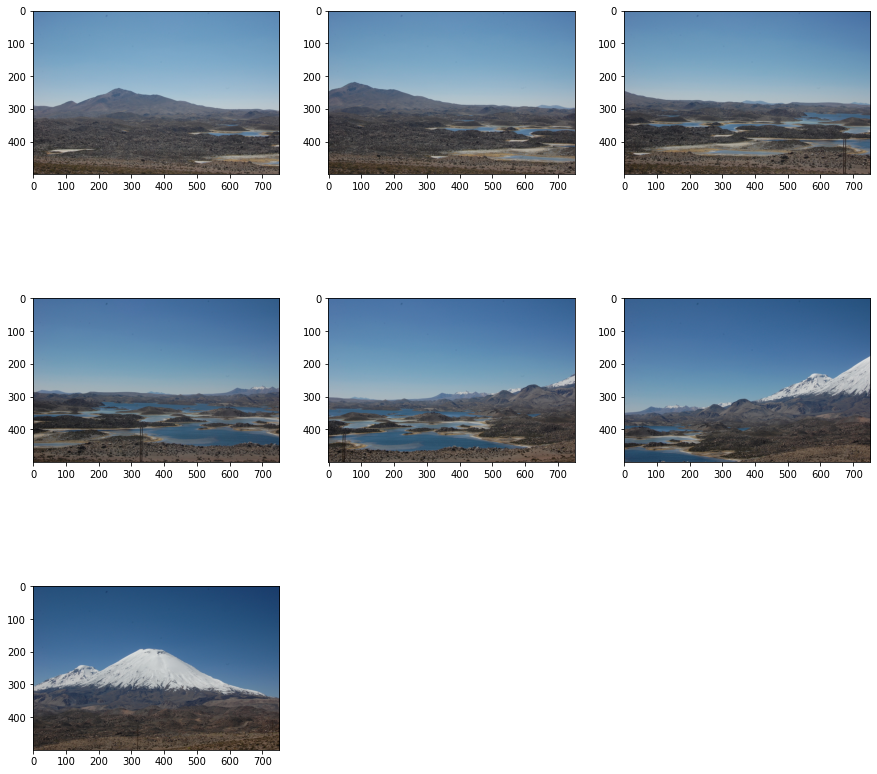

In [4]:
def stiching():
  images = [cv2.imread(image) for image in sorted(glob.glob('Imagenes/DSC_41*.JPG'), reverse=True)]
  perspective = None  
  computation = None
  h = None
  visualizeImages(images)
  for idx in range(1, len(images)):
    if idx == 1:
      curr_images = [images[idx-1], images[idx]]
      computation = computeKeyPointsAndDescriptors(curr_images)
      #drawKeyPoints(curr_images, computation)
      h = findHomography(curr_images, computation, idx)
      perspective = createBlending(curr_images, h, idx)
      cv2.imwrite('stitching_{}.JPG'.format(idx), perspective)    
    else:
      curr_images = [perspective, images[idx]]
      computation = computeKeyPointsAndDescriptors(curr_images)
      #drawKeyPoints(curr_images, computation)
      h = findHomography(curr_images, computation, idx)
      perspective = createBlending(curr_images, h, idx)
      cv2.imwrite('stitching_{}.JPG'.format(idx), perspective)
stiching()

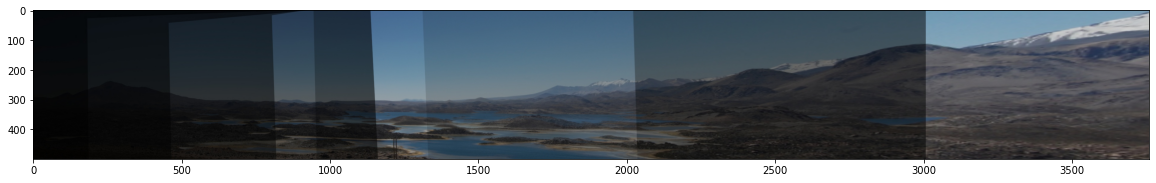

In [5]:
# Mostrar imagenes generadas
image = cv2.imread('stitching_4.JPG')
plt.figure(figsize=(20, 20))
plt.imshow(image[:,:,::-1])
plt.show()